# Data Split Creation

This notebook creates data splits used to evaluate gRNAde for multi-state design on structurally dissimilar clusters of RNAs.
The validation and test sets contain progressively more structurally flexible RNAs as measured by median RMSD among multiple available states for an RNA sequence.

Note that we manually inspected RNAs in validation and test sets to ensure that they are structured RNAs that have more than one 3D structure available with sufficiently high C4' RMSD among them.
Clusters with very small fragments of RNA or unstructured elements were excluded from the validation and test set even if they had large C4' RMSD among entries in the cluster.

**Workflow:**
1. Cluster RNA sample sequences into groups based on structural similarity -- qTMclust for efficiently applying US-align with similarity threshold 0.45.
2. Order the clusters based on a metric (median intra-sequence RMSD among available structures within the cluster).
3. Training, validation, and test splits become progressively harder.
    - Top 50 samples from clusters with highest metric -- test set (only clusters with less than 5 unique sequence/samples).
    - Next 50 samples from clusters with highest metric -- validation set (clusters with less than 5 unique sequences/samples).
    - Very large (> 1000 nts) RNAs -- training set.
4. If any samples were not assigned clusters, append them to the training set.

Note that we separate very large RNA samples (> 1000 nts) from clustering and directly add these to the training set, as it is unlikely that we want to redesign very large RNAs. We do not process very short RNA samples (< 10 nts).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import dotenv
dotenv.load_dotenv("../.env")

True

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import lovely_tensors as lt
lt.monkey_patch()

In [3]:
DATA_PATH = os.environ.get("DATA_PATH")

In [4]:
seq_to_data = torch.load(os.path.join(DATA_PATH, "processed.pt"))
df = pd.read_csv(os.path.join(DATA_PATH, "processed_df.csv"))
# df["cluster_structsim0.45"] = df["cluster_structsim0.45"].fillna(-1)
# df["cluster_seqid0.8"] = df["cluster_seqid0.8"].fillna(-1)
df

,id_list,rfam_list,eq_class_list,type_list,cluster_seqid0.8,cluster_structsim0.45,sequence,length,mean_rmsd,median_rmsd,num_structures
0,"['6WD5_1_2', '6WD1_1_2', '6WD9_1_2', '6OGI_1_2...","['5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA', '...","['10157', '10157', '10157', '10157', '10157', ...","['Protein-RNA Complex', 'Protein-RNA Complex',...",56,133,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,120,0.879151,0.778740,91
1,['3B58_1_B-C-A'],['unknown'],['02086'],['Solo RNA'],660,283,UCCCAGUCCACCGCGGUGAGAAGGGGGCAGAGAAACACACGAUCGU...,61,0.000000,0.000000,1
2,"['7M57_1_n-Y', '7M57_1_qq-bb', '4OQ9_1_S-h', '...","['unknown', 'unknown', 'unknown', 'unknown', '...","['20373', '20373', '24132', '20373', '20373', ...","['Protein-RNA Complex', 'Protein-RNA Complex',...",39,764,AAAAAAAAAAUUUUUUUUUU,20,0.808048,0.749047,46
3,['6DTI_1_X-W'],['SSU_rRNA_bacteria'],['63494'],['Protein-RNA Complex'],11,929,GGCUACGAACCCGUA,15,0.000000,0.000000,1
4,['3KTW_1_C'],['unknown'],['32874'],['Protein-RNA Complex'],438,171,AGAUAGUCGUGGGUUCCCUUUCUGGAGGGAGAGGGAAUUCCACGUU...,96,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
4218,['354D_1_A-B'],['unknown'],['63943'],['DNA-RNA Hybrid'],1002,656,CCGAUGGUAGUGGCGAGAGUA_C,23,0.000000,0.000000,1
4219,['2DER_1_D'],['tRNA'],['79496'],['Protein-RNA Complex'],567,212,CCCCUUCGUCUAGAGGCCCAGGACACCGCCCUUUCACGGCGGUAAC...,71,0.000000,0.000000,1
4220,['4ILL_1_C'],['unknown'],['31263'],['Protein-RNA Complex'],42,789,GCUAAUCUACUAUAGAA,17,0.000000,0.000000,1
4221,['3T1Y_1_X-W'],['SSU_rRNA_bacteria'],['61644'],['Protein-RNA Complex'],4,1048,AAGGACUUUAC,11,0.000000,0.000000,1


In [5]:
# Number of clusters
len(df["cluster_structsim0.45"].unique())

1104

In [6]:
cluster_to_seq_idx_list = {}     # cluster -> list of seq idx in seq_to_data dict
cluster_to_pdb_ids_list = {}     # cluster -> list of pdb ids
excluded_idx = []                # indexes which will be excluded from val/test set

unclustered_id = int(df["cluster_structsim0.45"].max()) + 1  # some clusters were not assigned

for seq_idx, data in enumerate(tqdm(seq_to_data.values())):
    # exclude very long sequences which are generally ribosomal RNAs
    if len(data["sequence"]) > 1000:
        excluded_idx.append(seq_idx)
    
    else:
        cluster = int(data["cluster_structsim0.45"])
        if cluster == -1:
            # assign unclustered sequences to a new cluster
            cluster = unclustered_id
            unclustered_id += 1

        if cluster not in cluster_to_seq_idx_list:
            cluster_to_seq_idx_list[cluster] = []
            cluster_to_pdb_ids_list[cluster] = []
        cluster_to_seq_idx_list[cluster].append(seq_idx)
        cluster_to_pdb_ids_list[cluster].extend(data["id_list"])

print(f"Number of excluded sequences (> 1000 nts): {len(excluded_idx)}")

100%|██████████| 4223/4223 [00:00<00:00, 1205591.19it/s]

Number of excluded sequences (> 1000 nts): 1146


In [7]:
# Cluster sizes: number of sequences in each cluster
cluster_ids = list(cluster_to_seq_idx_list.keys())
cluster_sizes = [len(list) for list in cluster_to_seq_idx_list.values()]

# Median RMSD for each cluster (in same order as cluster_id list)
cluster_median_rmsds = []
for cluster, seq_idx_list in cluster_to_seq_idx_list.items():
    rmsds = []
    for seq_idx in seq_idx_list:
        sequence = list(seq_to_data.keys())[seq_idx]  # ugh, how longwinded...
        _rmsds = list(seq_to_data[sequence]["rmsds_list"].values())
        if len(_rmsds) > 0:
            rmsds += _rmsds
    if len(rmsds) > 0:
        cluster_median_rmsds.append(np.median(rmsds))
    else:
        cluster_median_rmsds.append(0.0)

df_split = pd.DataFrame({
    'Cluster ID': cluster_ids,
    'PDB IDs': [", ".join(pdb_ids) for pdb_ids in cluster_to_pdb_ids_list.values()],
    'Cluster size': cluster_sizes,
    'Median intra-sequence RMSD': cluster_median_rmsds,
})
# Sort df_split by median intra-sequence RMSD
df_split = df_split.sort_values(by="Median intra-sequence RMSD", ascending=False)
df_split

,Cluster ID,PDB IDs,Cluster size,Median intra-sequence RMSD
634,499,"4H5O_1_L, 4H5O_1_K, 8IUO_1_F",1,27.366238
570,745,"7QP6_1_7, 7M2T_1_V-WW, 7M57_1_V-WW",1,24.670719
120,279,"8FF4_1_M, 8FD3_1_M, 8FF5_1_M, 8FCJ_1_M, 8FD2_1...",1,22.066985
355,46,"6Q97_1_4, 4V6T_1_AV, 6Q98_1_4, 6Q9A_1_4, 7ACR_...",4,16.800173
950,238,"2OIU_1_P, 2OIU_1_Q",1,15.910386
...,...,...,...,...
605,160,"8AC0_1_R, 8ACP_1_R, 7XUE_1_R, 7XUI_1_R",4,0.000000
608,687,"8P4D_1_P, 8P4B_1_P, 8P4C_1_P",3,0.000000
609,1074,7MSF_1_S,1,0.000000
611,112,7R6K_1_1,1,0.000000


In [8]:
# RMSD split preparation

# Clusters with valid RNAs that should be included in the test/val set
# We have manually inspected the RNAs in these clusters to ensure that
# they are structured RNAs that have more than one 3D structure available
# with sufficiently high C4' RMSD among them.
valid_clusters = [
    46, 238, 309, 110, 582, 100, 371, 63, 137, 44, 722, 453, 304,
    507, 295, 326, 104, 508, 187, 140, 652, 245, 308, 667, 139, 517,
    275, 286, 381, 48, 127, 255, 385, 301, 258, 108, 966, 996, 691,
    814, 409, 501, 1068, 402, 762, 205, 584, 527, 289, 569, 650, 422,
    254, 619, 287, 737, 391, 188, 393, 252, 451, 319, 1059, 82
]

# Clusters with very small fragments of RNA or unstructured elements, 
# not suitable for test/val set, even though the C4' RMSD among entries
# in the cluster may be large. We have manually inspected the RNAs in these
# clusters to ensure that they are unstructured or extracted from larger
# complexes, thus being unsuitable for evaluation. 
invalid_clusters = [
    499, 745, 279, 414, 218, 1015, 1019, 1095, 426, 1099, 1088, 967, 954,
    807, 303, 1020, 960, 1052, 846, 879, 138, 1041, 76, 937, 712, 410,
    856, 1009, 530, 392
]

# Initialize lists for test, validation, and training set indexes
test_idx_list = []
test_pdb_ids_list = []
val_idx_list = []
val_pdb_ids_list = []
train_idx_list = []
train_pdb_ids_list = []

# Training, validation, and test splits become progressively harder.
#     - Top 100 samples from clusters with highest metric -- test set (cluster_size < 5).
#     - Next 100 samples from clusters with highest metric -- validation set (cluster_size < 5).
#     - All remaining samples -- training set.
#     - Very large (> 1000 nts) RNAs -- training set.

for _, (cluster, pdb_ids, cluster_size, median_rmsd) in df_split.iterrows():
    seq_idx_list = cluster_to_seq_idx_list[cluster]
    assert cluster_size == len(seq_idx_list)

    # Test set
    if len(test_idx_list) < 50 and cluster_size < 5:
        # manually check each entry into the test/val set
        # s.t. it is not a random small fragment of RNA
        if cluster in valid_clusters:  
            test_idx_list += seq_idx_list
            test_pdb_ids_list += pdb_ids.split(", ")
        else:
            train_idx_list += seq_idx_list
            train_pdb_ids_list += pdb_ids.split(", ")
    
    # Validation set
    elif len(val_idx_list) < 50 and cluster_size < 5:
        # manually check each entry into the test/val set
        # s.t. it is not a random small fragment of RNA
        if cluster not in invalid_clusters:
            val_idx_list += seq_idx_list
            val_pdb_ids_list += pdb_ids.split(", ")
        else:
            train_idx_list += seq_idx_list
            train_pdb_ids_list += pdb_ids.split(", ")
    
    # Training set
    else:
        train_idx_list += seq_idx_list
        train_pdb_ids_list += pdb_ids.split(", ")

# Add all the sequences that were not assigned any clusters into the training set
try:
    assert len(test_idx_list) + len(val_idx_list) + len(train_idx_list) == len(list(seq_to_data.keys()))
except:
    train_idx_list += excluded_idx
    assert len(test_idx_list) + len(val_idx_list) + len(train_idx_list) == len(list(seq_to_data.keys()))

In [23]:
# Save split
torch.save(
    (train_idx_list, val_idx_list, test_idx_list), 
    os.path.join(DATA_PATH, "structsim_split_v2.pt")
)
# with open(os.path.join(DATA_PATH, "split_ids/train_ids_structsim_v2.txt"), "w") as f:
#     for id in train_pdb_ids_list:
#         f.write(f"{id}\n")

Split: train
Average median RMSD: 0.44 +- 1.27
Median number of structures: 1.00


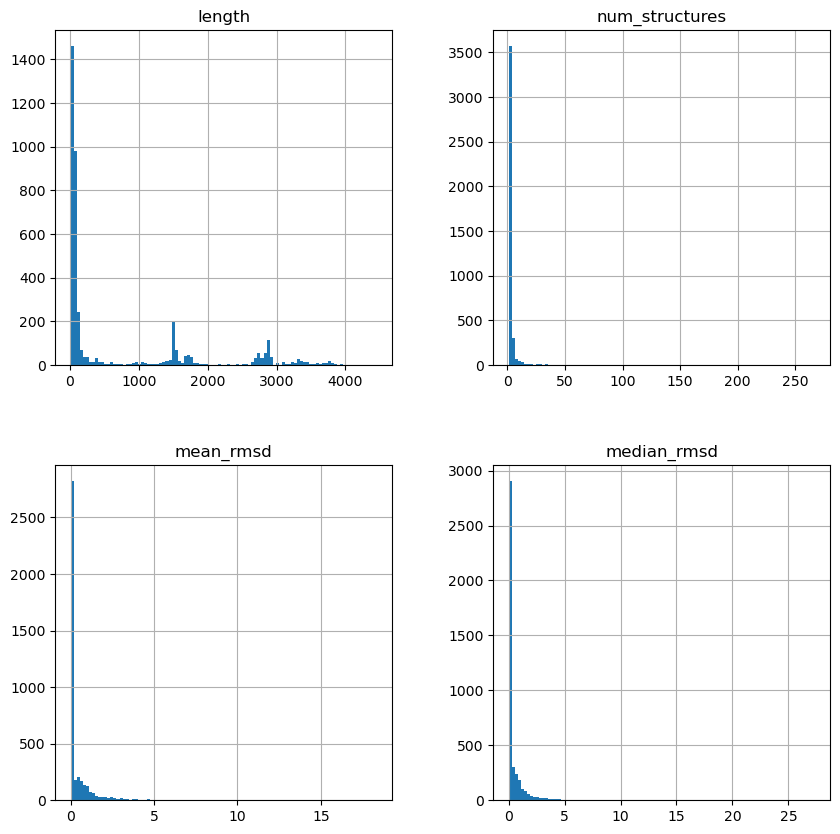

Split: val
Average median RMSD: 1.41 +- 0.86
Median number of structures: 2.00


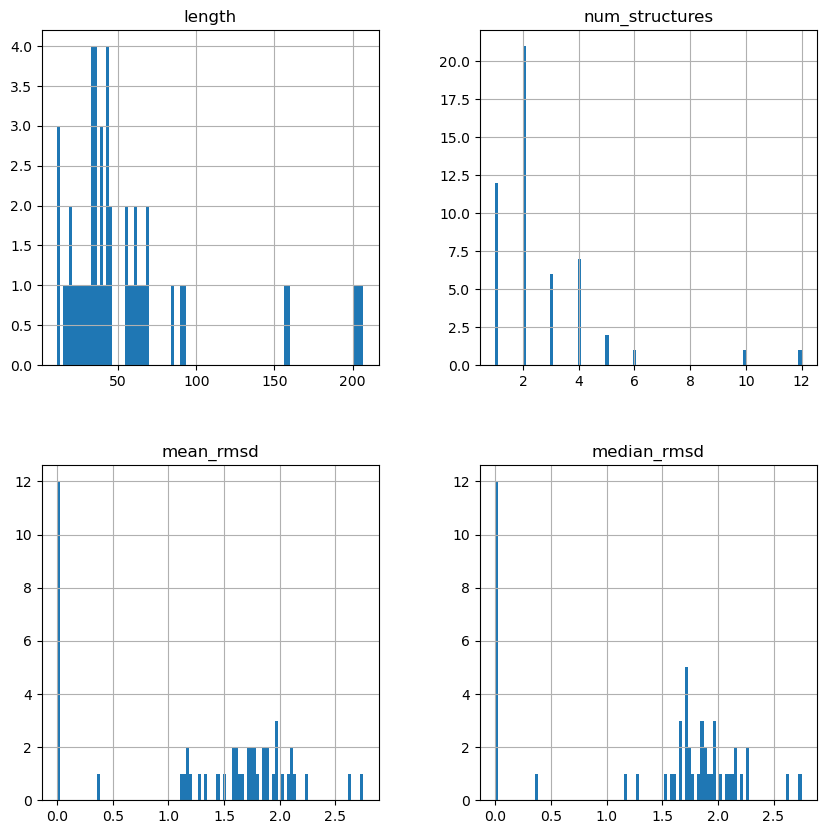

Split: test
Average median RMSD: 4.03 +- 4.94
Median number of structures: 2.00


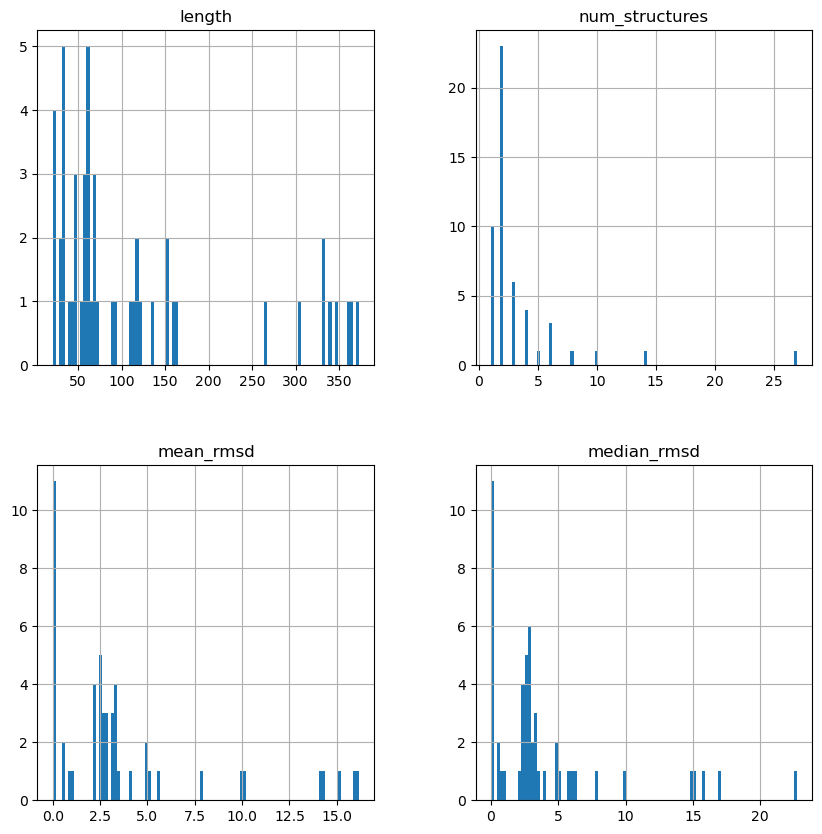

In [16]:
df["split"] = "train"
df.loc[val_idx_list, "split"] = "val"
df.loc[test_idx_list, "split"] = "test"

for split in ["train", "val", "test"]:
    print(f"Split: {split}")
    print(f"Average median RMSD: {df.loc[df.split == split]['median_rmsd'].mean():.2f} +- {df.loc[df.split == split]['median_rmsd'].std():.2f}")
    print(f"Median number of structures: {df.loc[df.split == split]['num_structures'].median():.2f}")
    df.loc[df.split == split].hist(column=["length", "num_structures", "mean_rmsd", "median_rmsd"], figsize=(10, 10), bins=100)
    plt.show()